In [39]:
%%writefile requirements.txt



tensorflow==2.17.0

keras==3.4.1

tensorflow-decision-forests==1.10.0

tensorflow-text==2.17.0

tf-keras==2.17.0

keras_cv

Overwriting requirements.txt


In [40]:
!pip install -r requirements.txt

In [1]:
# Set seed for reproducibility

seed = 42



# Import necessary libraries

import os



# Set environment variables before importing modules

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

os.environ['PYTHONHASHSEED'] = str(seed)

os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'



# Suppress warnings

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

warnings.simplefilter(action='ignore', category=Warning)



# Import necessary modules

import logging

import random

import numpy as np



# Set seeds for random number generators in NumPy and Python

np.random.seed(seed)

random.seed(seed)



# Import TensorFlow and Keras

import tensorflow as tf

from tensorflow import keras as tfk

from tensorflow.keras import layers as tfkl

from tensorflow.keras.utils import to_categorical

# Set seed for TensorFlow

tf.random.set_seed(seed)

tf.compat.v1.set_random_seed(seed)



# Reduce TensorFlow verbosity

tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)



# Print TensorFlow version

print(tf.__version__)



# Import other libraries

import cv2

import keras_cv

from tensorflow.keras.applications.mobilenet import preprocess_input

from tensorflow.keras.applications import EfficientNetB0,DenseNet121

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

from sklearn.utils.class_weight import compute_class_weight

from PIL import Image

import matplotlib.gridspec as gridspec

import requests

from io import BytesIO

from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GroupNormalization, BatchNormalization



# Configure plot display settings

sns.set(font_scale=1.4)

sns.set_style('white')

plt.rc('font', size=14)

%matplotlib inline

2.16.1


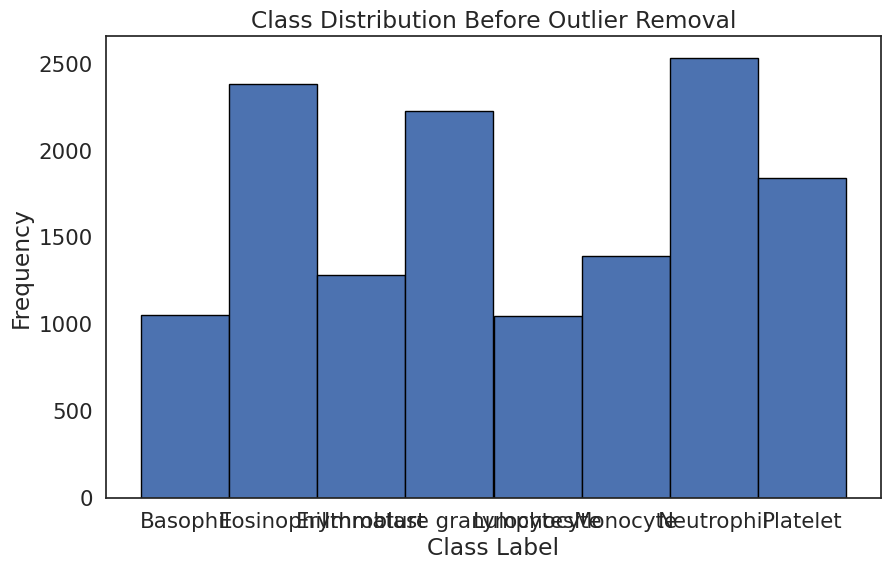

In [2]:
# Load the dataset

data = np.load('/kaggle/input/anndl-homework-1/training_set.npz')

X = data['images']

y = data['labels']



# Normalize the images

# X = tf.image.resize(X, (224, 224)).numpy()

X = X / 255.0

# X = tf.keras.applications.densenet.preprocess_input(X)

labels = to_categorical(y, num_classes=8)  # One-hot encode labels



# Flatten the image data for analysis

X_flat = X.reshape((X.shape[0], -1))

# Plot data distribution before outlier removal

plt.figure(figsize=(10, 6))

plt.hist(y, bins=np.arange(9) - 0.5, edgecolor='black')

plt.xticks(range(8), ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet'])

plt.xlabel('Class Label')

plt.ylabel('Frequency')

plt.title('Class Distribution Before Outlier Removal')

plt.show()

In [3]:
def print_unique_labels(labels):

    unique_labels = np.unique(labels)

    print(f'Unique labels in the dataset: {unique_labels}')



# Example usage

print_unique_labels(y)

Unique labels in the dataset: [0 1 2 3 4 5 6 7]


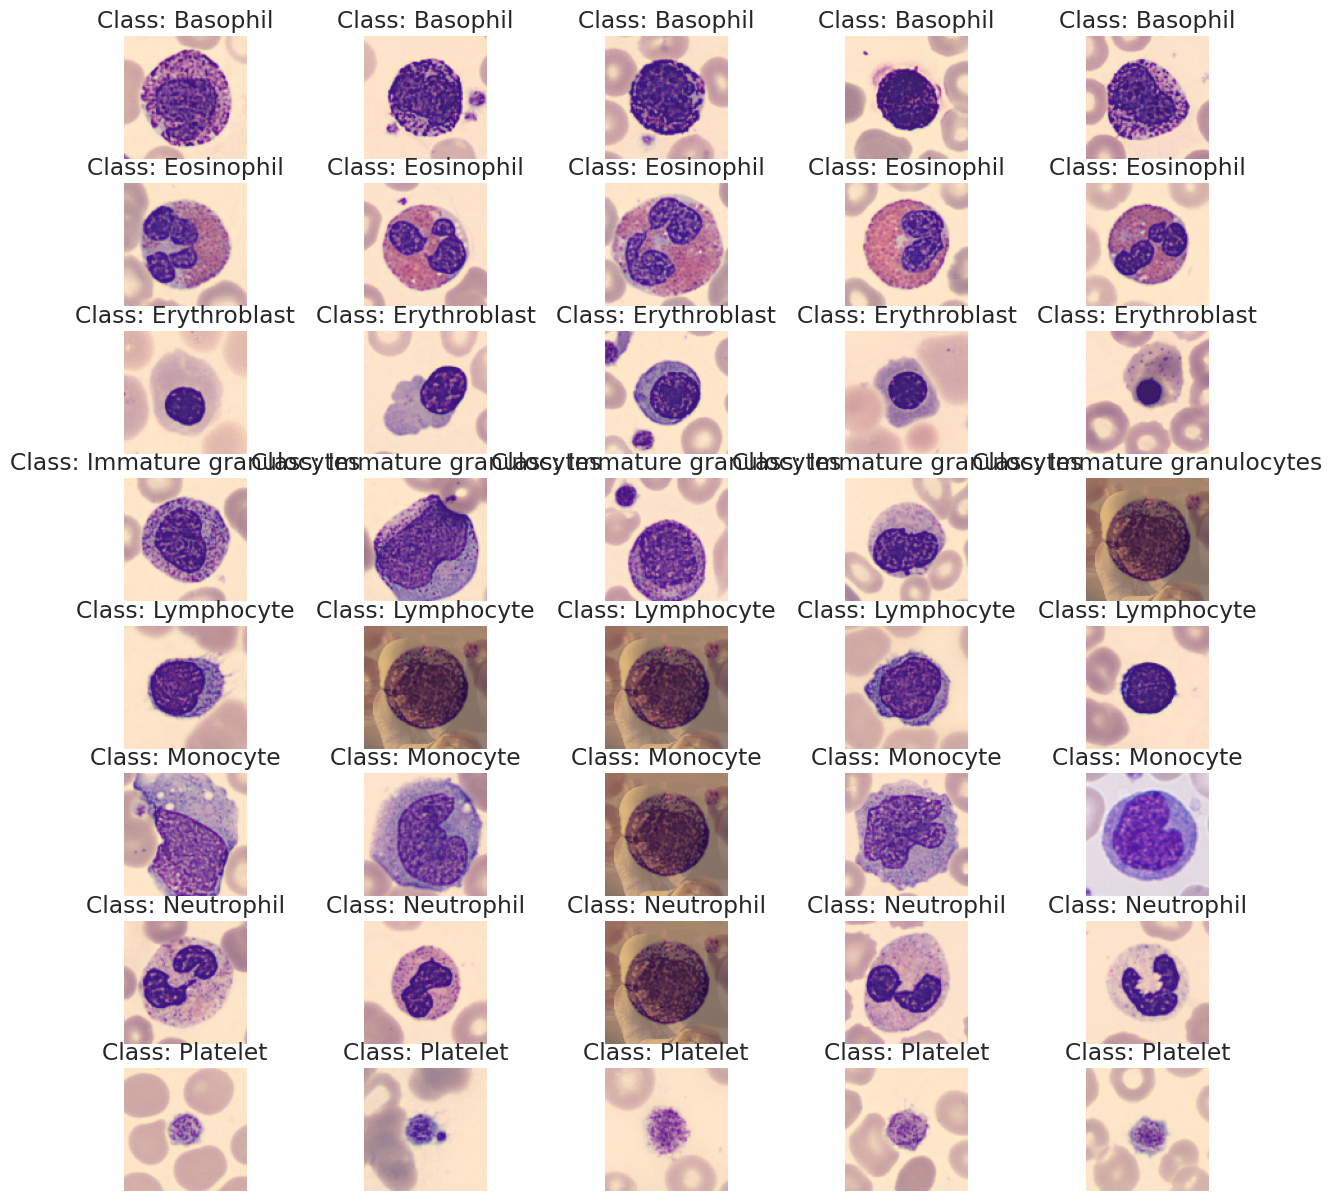

In [4]:
import matplotlib.pyplot as plt



def visualize_images_with_labels(X, y, class_names, num_samples=5):

    unique_labels = np.unique(y)

    plt.figure(figsize=(15, 15))

    for i, label in enumerate(unique_labels):

        indices = np.where(y == label)[0]

        selected_indices = np.random.choice(indices, num_samples, replace=False)

        for j, index in enumerate(selected_indices):

            plt.subplot(len(unique_labels), num_samples, i * num_samples + j + 1)

            plt.imshow(X[index])

            plt.title(f'Class: {class_names[label]}')

            plt.axis('off')

    plt.show()



class_names = ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']

visualize_images_with_labels(X, y, class_names)


In [5]:
# Calculate the mean pixel values

mean_pixel_values = np.mean(X_flat, axis=1)



# Function to print the image with the highest frequency of the mean pixel values

def print_image_with_highest_frequency(dataset, mean_values):

    # Find the mean value with the highest frequency

    unique, counts = np.unique(mean_values, return_counts=True)

    max_frequency_index = np.argmax(counts)

    highest_freq_mean_value = unique[max_frequency_index]

    highest_freq_count = counts[max_frequency_index]



    # Find the index of the first image with this mean value

    index = np.where(mean_values == highest_freq_mean_value)[0][0]



    # Plot the image with the highest frequency mean value

    plt.figure(figsize=(5, 5))

    plt.imshow(dataset[index])

    plt.title(f'Image with highest frequency mean value: {highest_freq_mean_value}\nFrequency: {highest_freq_count}')

    plt.axis('off')

    plt.show()

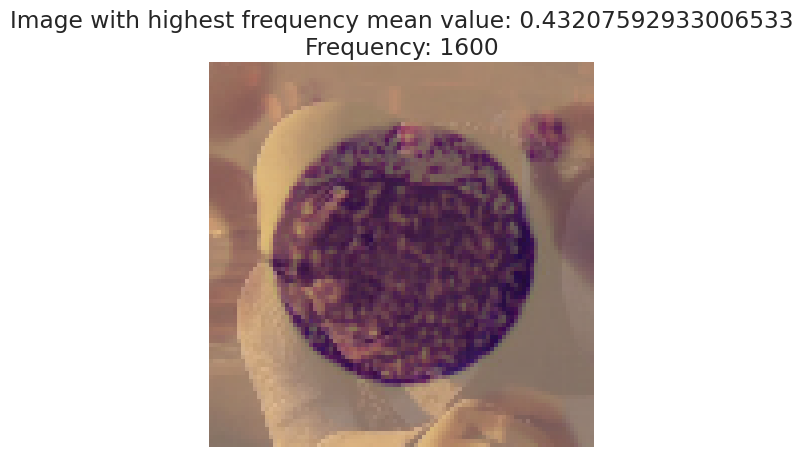

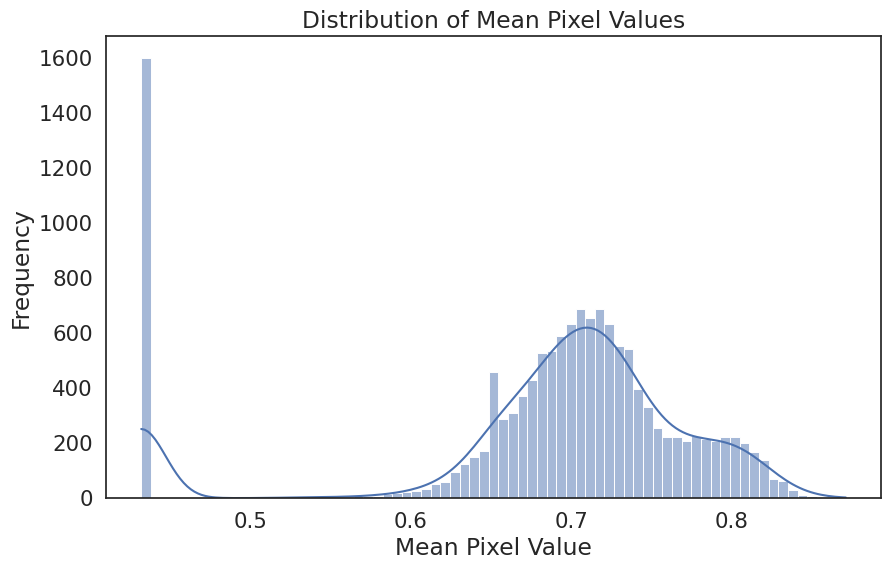

In [6]:
# Example usage

print_image_with_highest_frequency(X, mean_pixel_values)



# Plotting the distribution of mean pixel values

plt.figure(figsize=(10, 6))

sns.histplot(mean_pixel_values, kde=True)

plt.title('Distribution of Mean Pixel Values')

plt.xlabel('Mean Pixel Value')

plt.ylabel('Frequency')

plt.show()



#show me the indexes of these images with the pixel value


Indexes of images with mean pixel value 0.43207592933006533: [11959 11960 11961 ... 13556 13557 13558]


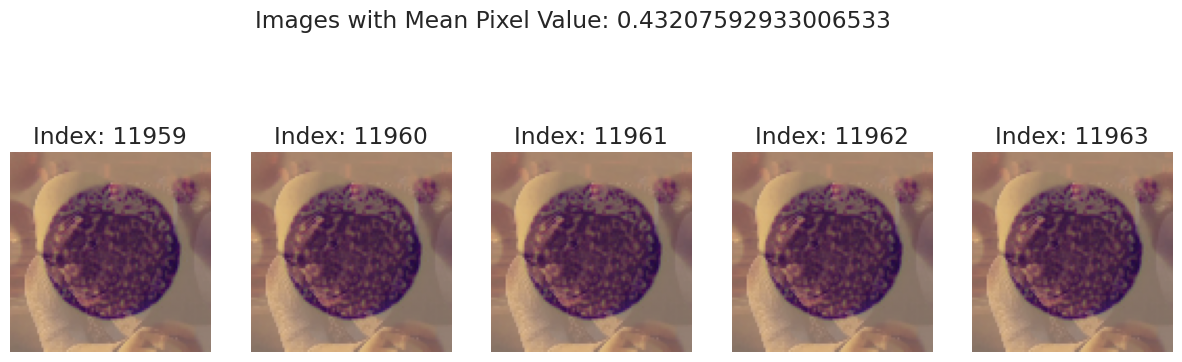

None


In [7]:
def get_indexes_and_print_images(dataset, mean_values, specific_mean_value):

    # Find the indexes of images with the specific mean value

    indexes = np.where(mean_values == specific_mean_value)[0]



    if len(indexes) == 0:

        print(f'No images found with mean pixel value {specific_mean_value}')

        return



    print(f'Indexes of images with mean pixel value {specific_mean_value}: {indexes}')



    # Plot some of the images with the specific mean value

    plt.figure(figsize=(15, 5))

    for i in range(min(5, len(indexes))):

        plt.subplot(1, 5, i + 1)

        plt.imshow(dataset[indexes[i]])

        plt.axis('off')

        plt.title(f'Index: {indexes[i]}')

    plt.suptitle(f'Images with Mean Pixel Value: {specific_mean_value}')

    plt.show()

given_mean_value = 0.43207592933006533

print(get_indexes_and_print_images(X, mean_pixel_values, given_mean_value))


In [8]:
# Remove images with mean pixel value of 0.6524119746278141

specific_value = 0.6524119746278141

remove_indices = mean_pixel_values == specific_value

removed_count = np.sum(remove_indices)

X = X[~remove_indices]

y = y[~remove_indices]

X_flat = X.reshape((X.shape[0], -1))

In [9]:
# Check if the images with the specific mean value are removed

remaining_specific_value_count = np.sum(mean_pixel_values[~remove_indices] == specific_value)

print(f'Number of images with mean pixel value {specific_value} removed: {removed_count}')

print(f'Number of images with mean pixel value {specific_value} remaining: {remaining_specific_value_count}')

Number of images with mean pixel value 0.6524119746278141 removed: 200
Number of images with mean pixel value 0.6524119746278141 remaining: 0


In [10]:
mean_pixel_values = np.mean(X_flat, axis=1)

specific_value = 0.43207592933006533

remove_indices = mean_pixel_values == specific_value

removed_count = np.sum(remove_indices)

X = X[~remove_indices]

y = y[~remove_indices]

X_flat = X.reshape((X.shape[0], -1))

In [11]:
# Check if the images with the specific mean value are removed

remaining_specific_value_count = np.sum(mean_pixel_values[~remove_indices] == specific_value)

print(f'Number of images with mean pixel value {specific_value} removed: {removed_count}')

print(f'Number of images with mean pixel value {specific_value} remaining: {remaining_specific_value_count}')

Number of images with mean pixel value 0.43207592933006533 removed: 1600
Number of images with mean pixel value 0.43207592933006533 remaining: 0


In [12]:
from collections import defaultdict

# Function to find duplicate images and their count

def find_duplicates(X):

    # Use a dictionary to store hashes of image data and corresponding indexes

    hash_dict = defaultdict(list)



    # Iterate through all images and store their hashes

    for i in range(len(X)):

        image_hash = hash(X_flat[i].tostring())

        hash_dict[image_hash].append(i)



    # Find duplicate images

    duplicates = {k: v for k, v in hash_dict.items() if len(v) > 1}

    duplicate_count = sum(len(v) - 1 for v in duplicates.values())



    print(f'Number of duplicate images found: {duplicate_count}')

    return duplicates



# Function to get indexes of duplicate images

def get_duplicate_indexes(duplicates):

    duplicate_indexes = [indexes[1:] for indexes in duplicates.values()]

    duplicate_indexes = [index for sublist in duplicate_indexes for index in sublist]

    return duplicate_indexes



# Find duplicate images

duplicates = find_duplicates(X)



# Get indexes of duplicate images

duplicate_indexes = get_duplicate_indexes(duplicates)

print(f'Indexes of duplicate images: {duplicate_indexes}')


Number of duplicate images found: 8
Indexes of duplicate images: [4761, 11026, 3440, 11566, 11575, 11856, 10734, 9084]


In [13]:
# Function to find and remove duplicate images

def remove_duplicates(X, y):

    # Use the previously found duplicate indexes to remove duplicates

    X_new = np.delete(X, duplicate_indexes, axis=0)

    y_new = np.delete(y, duplicate_indexes, axis=0)



    print(f'Number of duplicate images removed: {len(duplicate_indexes)}')

    return X_new, y_new



# Remove duplicates from the dataset

X, y = remove_duplicates(X, y)

Number of duplicate images removed: 8


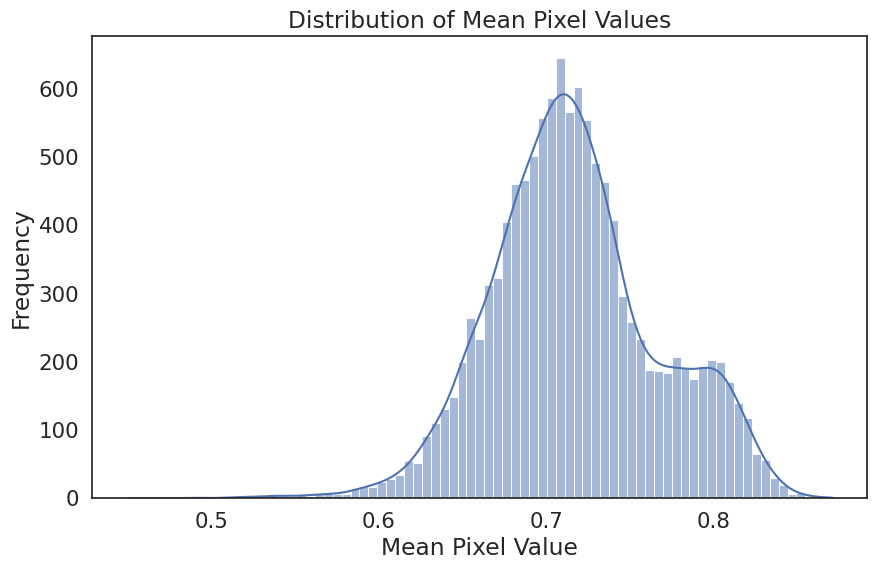

In [14]:
# Flatten the image data for analysis

X_flat = X.reshape((X.shape[0], -1))

# Calculate the mean pixel values

mean_pixel_values = np.mean(X_flat, axis=1)

# Plotting the distribution of mean pixel values

plt.figure(figsize=(10, 6))

sns.histplot(mean_pixel_values, kde=True)

plt.title('Distribution of Mean Pixel Values')

plt.xlabel('Mean Pixel Value')

plt.ylabel('Frequency')

plt.show()

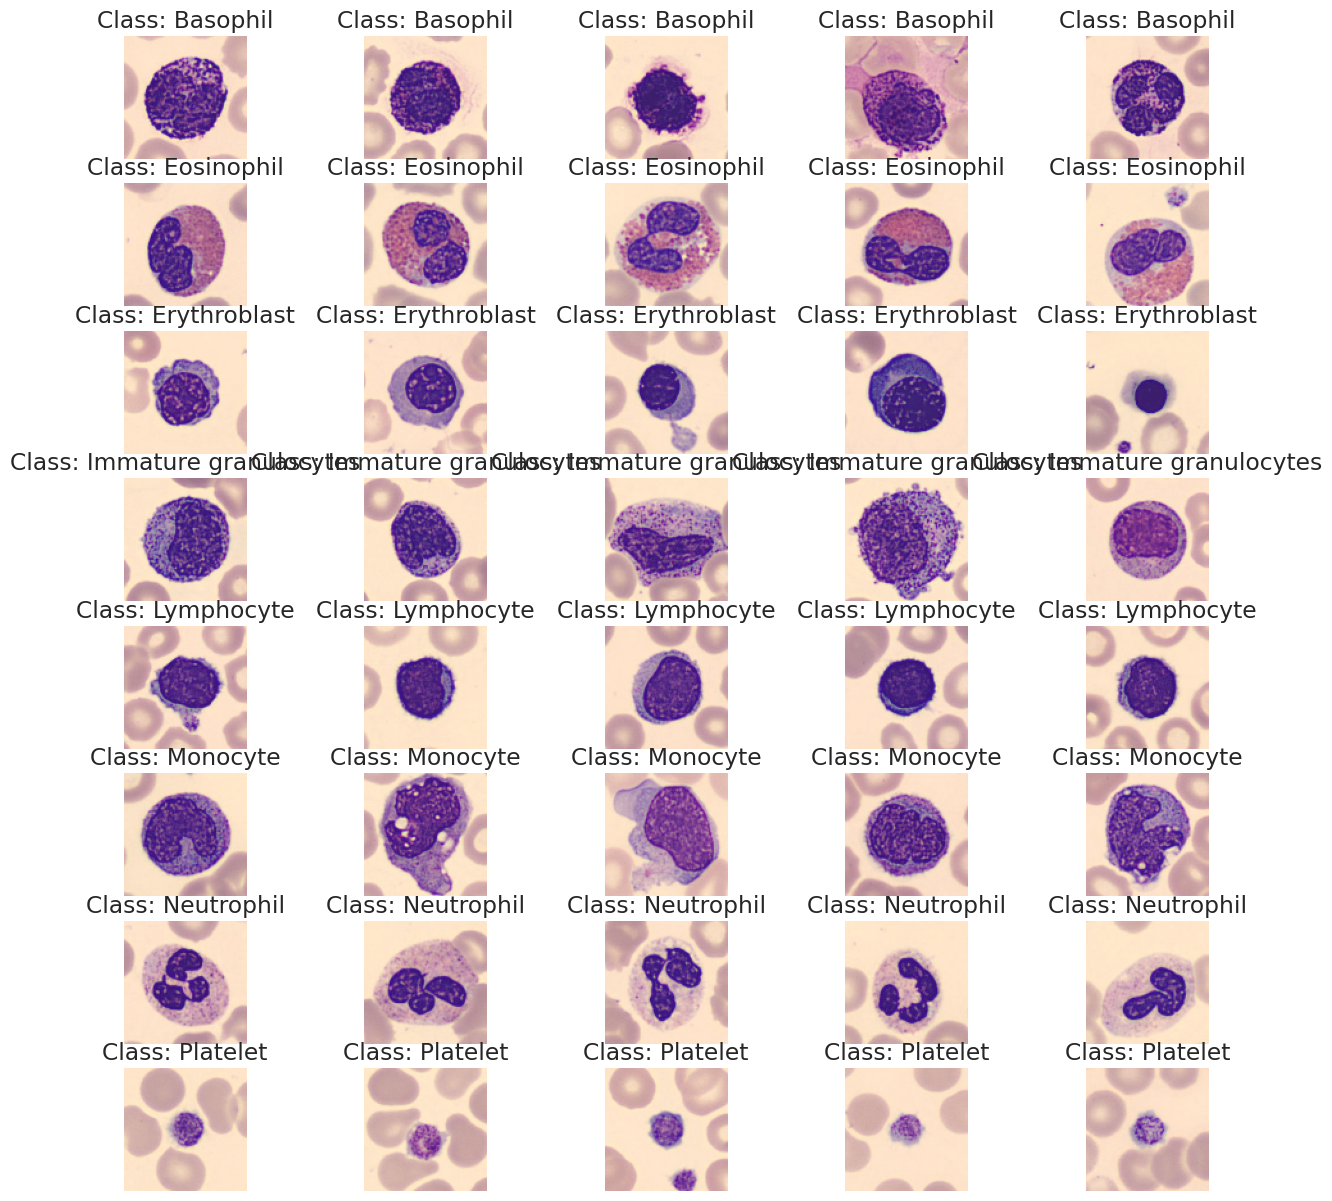

In [15]:
import matplotlib.pyplot as plt



def visualize_images_with_labels(X, y, class_names, num_samples=5):

    unique_labels = np.unique(y)

    plt.figure(figsize=(15, 15))

    for i, label in enumerate(unique_labels):

        indices = np.where(y == label)[0]

        selected_indices = np.random.choice(indices, num_samples, replace=False)

        for j, index in enumerate(selected_indices):

            plt.subplot(len(unique_labels), num_samples, i * num_samples + j + 1)

            plt.imshow(X[index])

            plt.title(f'Class: {class_names[label]}')

            plt.axis('off')

    plt.show()



class_names = ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']

visualize_images_with_labels(X, y, class_names)


In [16]:
X = X * 255.0

# X = tf.keras.applications.densenet.preprocess_input(X)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print shapes of the datasets

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (8365, 96, 96, 3), y_train shape: (8365, 1)
X_val shape: (1793, 96, 96, 3), y_val shape: (1793, 1)
X_test shape: (1793, 96, 96, 3), y_test shape: (1793, 1)


In [17]:
# Number of training epochs

epochs = 150



# Batch size for training

batch_size = 64



# Learning rate: step size for updating the model's weights

learning_rate = 0.001

num_classes = 8

# Print the defined parameters

print("Epochs:", epochs)

print("Batch Size:", batch_size)

print("Learning Rare:", learning_rate)

Epochs: 150
Batch Size: 64
Learning Rare: 0.001


In [18]:
# Mixed precision
from keras import mixed_precision
mixed_precision.set_global_policy('float32')

In [19]:
# # Define a sequential model for image augmentation with various transformations
# augmentation_layer = tf.keras.Sequential([
#     # tf.keras.layers.RandomFlip("horizontal_and_vertical"),
#     # tf.keras.layers.RandomRotation(0.5),  # More aggressive rotation
#     # tf.keras.layers.RandomZoom(0.5, 0.5),  # Larger zoom range
#     # tf.keras.layers.RandomContrast(0.7),  # Higher contrast adjustment
#     # tf.keras.layers.RandomBrightness(0.6),  # Increased brightness adjustment
#     # tf.keras.layers.RandomTranslation(0.3, 0.3),  # Larger translations
#     # tf.keras.layers.GaussianNoise(0.1),  # Adding Gaussian noise for robustness
#     # tf.keras.layers.RandomCrop(200, 200)  # Random cropping to introduce more variability

In [20]:
import tensorflow as tf
import keras_cv

# Define RandAugment and AugMix
randaugment = keras_cv.layers.RandAugment(
    value_range=(0, 255), augmentations_per_image=2, magnitude=0.6
)
augmix = keras_cv.layers.AugMix(
    value_range=(0, 255), severity=0.6
)

batch_size_aug = 35

# Split X_train into batches
X_train_batches = tf.split(X_train, num_or_size_splits=X_train.shape[0] // batch_size_aug, axis=0)

# RandAugment
augmented_batches = []
for i, batch in enumerate(X_train_batches):
    if i % 10 == 0:  # Print every 10th batch
        print(f"Processing batch {i} with shape: {batch.shape}")  # Print before augmentation
    augmented_batch = randaugment(batch)
    if i % 10 == 0:  # Print every 10th batch
        print(f"Augmented batch {i} shape: {augmented_batch.shape}")  # Print after augmentation
    augmented_batches.append(augmented_batch)

X_train_augmented = np.concatenate(augmented_batches, axis=0)
del augmented_batches

X_train_batches = tf.split(X_train_augmented, num_or_size_splits=X_train.shape[0] // batch_size_aug, axis=0)

# AugMix
augmented_batches = []
for i, batch in enumerate(X_train_batches):
    if i % 10 == 0:  # Print every 10th batch
        print(f"Processing batch {i} with shape: {batch.shape}")  # Print before augmentation
    augmented_batch = augmix(batch)
    if i % 10 == 0:  # Print every 10th batch
        print(f"Augmented batch {i} shape: {augmented_batch.shape}")  # Print after augmentation
    augmented_batches.append(augmented_batch)

X_train_augmented = np.concatenate(augmented_batches, axis=0)
del augmented_batches

augmentation_layer = None

Processing batch 0 with shape: (35, 96, 96, 3)
Augmented batch 0 shape: (35, 96, 96, 3)
Processing batch 10 with shape: (35, 96, 96, 3)
Augmented batch 10 shape: (35, 96, 96, 3)
Processing batch 20 with shape: (35, 96, 96, 3)
Augmented batch 20 shape: (35, 96, 96, 3)
Processing batch 30 with shape: (35, 96, 96, 3)
Augmented batch 30 shape: (35, 96, 96, 3)
Processing batch 40 with shape: (35, 96, 96, 3)
Augmented batch 40 shape: (35, 96, 96, 3)
Processing batch 50 with shape: (35, 96, 96, 3)
Augmented batch 50 shape: (35, 96, 96, 3)
Processing batch 60 with shape: (35, 96, 96, 3)
Augmented batch 60 shape: (35, 96, 96, 3)
Processing batch 70 with shape: (35, 96, 96, 3)
Augmented batch 70 shape: (35, 96, 96, 3)
Processing batch 80 with shape: (35, 96, 96, 3)
Augmented batch 80 shape: (35, 96, 96, 3)
Processing batch 90 with shape: (35, 96, 96, 3)
Augmented batch 90 shape: (35, 96, 96, 3)
Processing batch 100 with shape: (35, 96, 96, 3)
Augmented batch 100 shape: (35, 96, 96, 3)
Processing

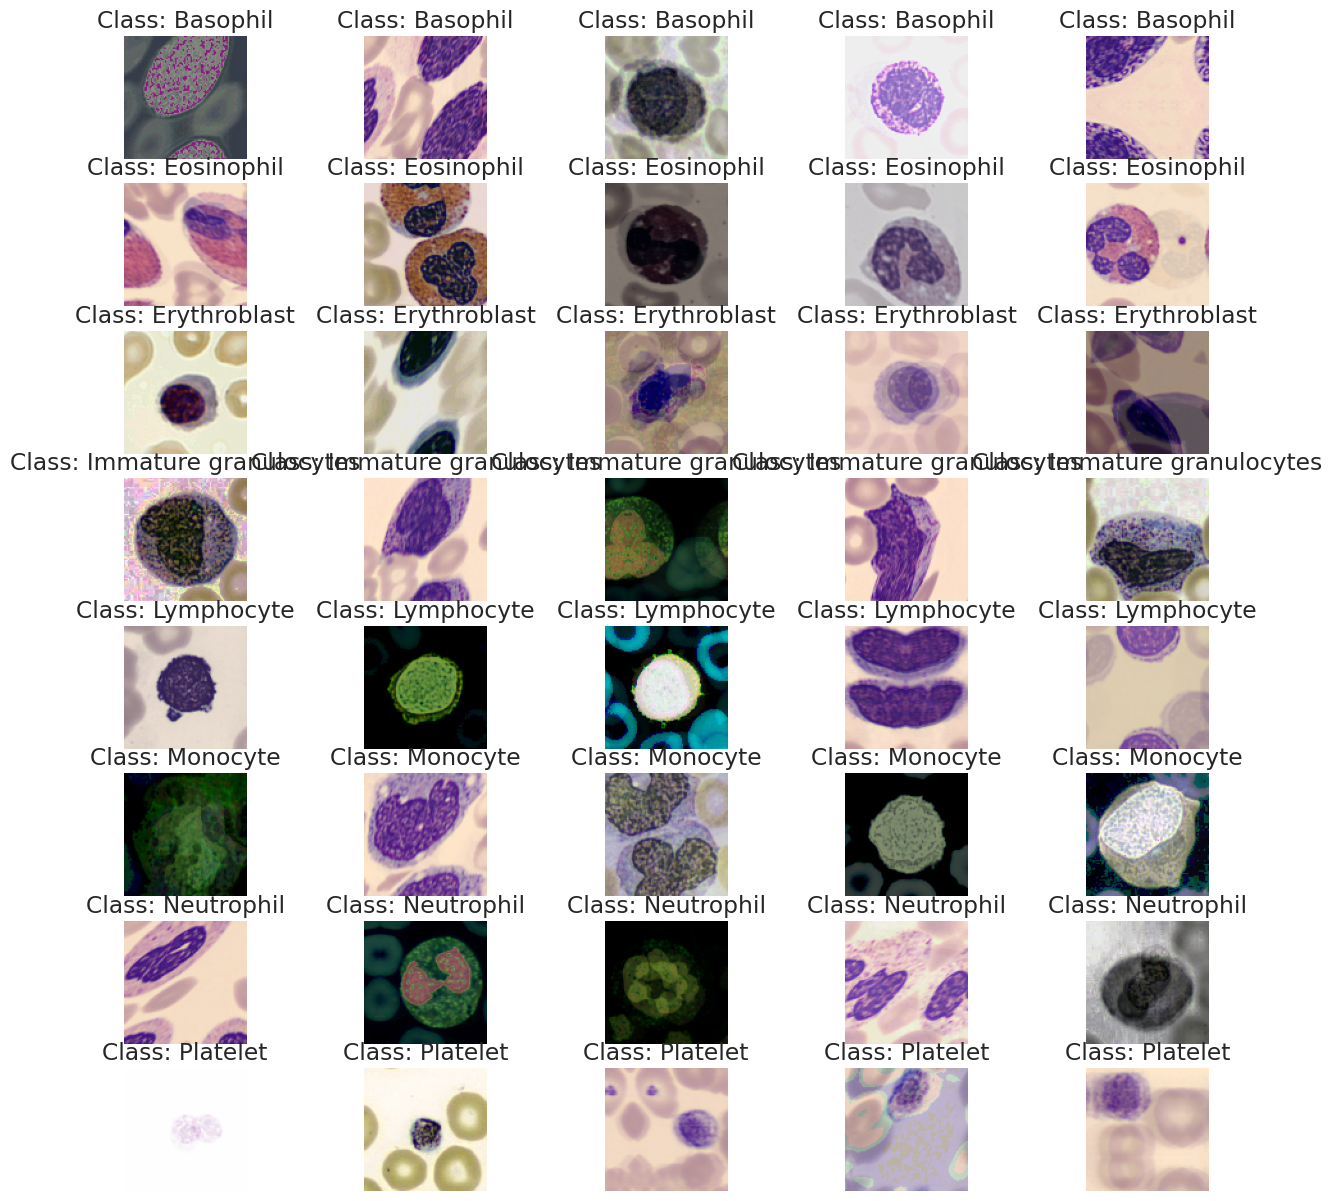

In [23]:
# Visualize the augmented images
visualize_images_with_labels(X_train_augmented/255.0, y_train, class_names)

In [24]:
# Calculate class weights to handle class imbalance

y_train_classes = np.argmax(y_train, axis=1)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)

class_weight_dict = dict(enumerate(class_weights))



def build_model(input_shape=(96, 96, 3), num_classes=8, learning_rate=0.0001,augmentation = None, seed=42, freeze_layers=True):

    # Set the random seed for reproducibility

    tf.random.set_seed(seed)



# Load the DenseNet121 model with pre-trained ImageNet weights

    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)



    if freeze_layers is True:

        base_model.trainable = False

    else:



        base_model.trainable = True



        fine_tune_at = 250



        # Freeze all the layers before the `fine_tune_at` layer

        for layer in base_model.layers[:fine_tune_at]:

            layer.trainable = False



    print("Number of layers in the base model: ", len(base_model.layers))

    # Define the input layer

    input_layer = tfkl.Input(shape=input_shape, name='Input')



    if augmentation is None:

        x = input_layer

    else:

        x = augmentation_layer(input_layer)



    x = tf.keras.layers.Resizing(96, 96)(x)

    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)



    x = base_model(x, training=False)

     # Add global pooling to reduce the feature maps

    x = GlobalAveragePooling2D()(x)



    # Add fully connected dense layers to improve feature extraction

    x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

    x = Dropout(0.5)(x)



    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

    x = Dropout(0.5)(x)



    # Final output layer

    output_layer = Dense(8, activation='softmax', dtype='float32')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='TransferLearning_DenseNet')



    # Compile the model with categorical crossentropy loss and Adam optimizer

    loss = tf.keras.losses.SparseCategoricalCrossentropy()

    optimizer = tf.keras.optimizers.Lion(learning_rate=learning_rate)

    metrics = ['accuracy']

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)



    # Return the compiled model

    return model


In [25]:
# Build and train the model with frozen layers first

model = build_model(input_shape=(96, 96, 3), num_classes=8, learning_rate= learning_rate, augmentation = augmentation_layer, freeze_layers=True)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Number of layers in the base model:  427


In [26]:
# Define callbacks

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

# mixed_precision = tf.keras.mixed_precision.Policy('mixed_float16')

# tf.keras.mixed_precision.set_global_policy(mixed_precision)

In [27]:
history = model.fit(

    x=X_train_augmented,

    y=y_train,
    # train_dataset,
    
    batch_size=batch_size,

    epochs=epochs,

    validation_data=(X_val, y_val),

    class_weight=class_weight_dict,

    callbacks=[early_stopping, lr_reduce]

).history



# Calculate and print the final validation accuracy

final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)

print(f'Final validation accuracy: {final_val_accuracy}%')


Epoch 1/150


I0000 00:00:1732278445.045420     206 service.cc:145] XLA service 0x5be29a84f350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732278445.045473     206 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732278445.045478     206 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  3/131 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.1311 - loss: 5.3294 

I0000 00:00:1732278458.856619     206 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/131 ━━━━━━━━━━━━━━━━━━━━ 57s 240ms/step - accuracy: 0.3800 - loss: 3.9689 - val_accuracy: 0.7217 - val_loss: 5.6074 - learning_rate: 0.0010
Epoch 2/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.5197 - loss: 5.7253 - val_accuracy: 0.7351 - val_loss: 3.0577 - learning_rate: 0.0010
Epoch 3/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.5195 - loss: 3.3574 - val_accuracy: 0.6905 - val_loss: 2.8924 - learning_rate: 0.0010
Epoch 4/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4834 - loss: 3.3952 - val_accuracy: 0.7066 - val_loss: 2.7021 - learning_rate: 0.0010
Epoch 5/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4962 - loss: 3.2665 - val_accuracy: 0.6871 - val_loss: 2.7014 - learning_rate: 0.0010
Epoch 6/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4909 - loss: 3.1785 - val_accuracy: 0.7055 - val_loss: 2.6141 - learning_rate: 0.0010
Epoch 7/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4724 - loss: 3.214

57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7187 - loss: 0.7802
Test Accuracy: 71.39%
Accuracy score over the test set: 0.7139
Precision score over the test set: 0.7347
Recall score over the test set: 0.7139
F1 score over the test set: 0.666


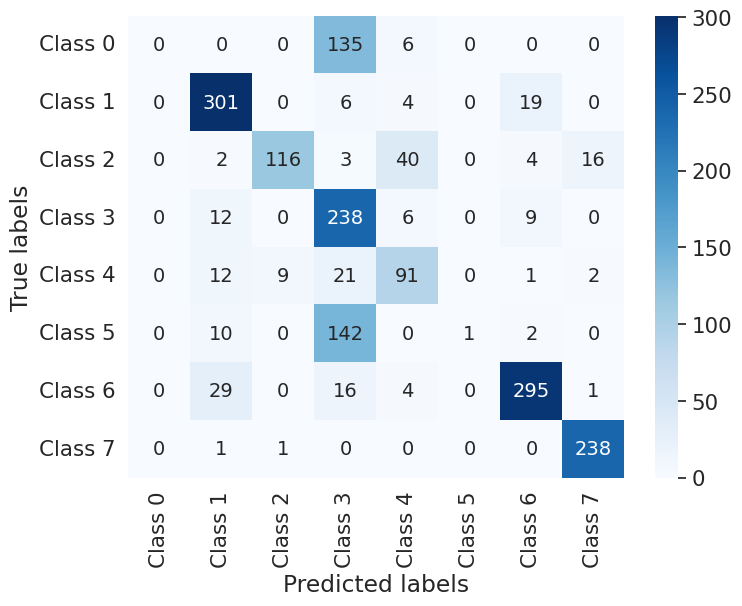

In [28]:
# Evaluate the model on the test set

test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')



# Predict class probabilities and get predicted classes

test_predictions = model.predict(X_test, verbose=0)

test_predictions = np.argmax(test_predictions, axis=-1)



# Extract ground truth classes

test_gt = y_test



# Calculate and display test set accuracy

test_accuracy = accuracy_score(test_gt, test_predictions)

print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')



# Calculate and display test set precision

test_precision = precision_score(test_gt, test_predictions, average='weighted')

print(f'Precision score over the test set: {round(test_precision, 4)}')



# Calculate and display test set recall

test_recall = recall_score(test_gt, test_predictions, average='weighted')

print(f'Recall score over the test set: {round(test_recall, 4)}')



# Calculate and display test set F1 score

test_f1 = f1_score(test_gt, test_predictions, average='weighted')

print(f'F1 score over the test set: {round(test_f1, 4)}')



# Compute the confusion matrix

cm = confusion_matrix(test_gt, test_predictions)



# Create labels combining confusion matrix values

labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)



# Plot the confusion matrix with class labels

plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=labels, fmt='', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'], cmap='Blues')

plt.xlabel('Predicted labels')

plt.ylabel('True labels')

plt.show()


In [29]:
# Build and train the model with frozen layers first

model = build_model(input_shape=(96, 96, 3), num_classes=8, learning_rate= learning_rate / 10, augmentation = augmentation_layer, freeze_layers=False)

Number of layers in the base model:  427


In [30]:
# Define callbacks

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

# mixed_precision = tf.keras.mixed_precision.Policy('mixed_float16')

# tf.keras.mixed_precision.set_global_policy(mixed_precision)

In [32]:
history = model.fit(

    x=X_train_augmented,

    y=y_train,

    batch_size=batch_size,

    epochs=epochs,

    validation_data=(X_val, y_val),

    class_weight=class_weight_dict,

    callbacks=[early_stopping, lr_reduce]

).history



# Calculate and print the final validation accuracy

final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)

print(f'Final validation accuracy: {final_val_accuracy}%')


Epoch 1/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.6903 - loss: 1.8296 - val_accuracy: 0.9241 - val_loss: 0.5725 - learning_rate: 1.0000e-04
Epoch 2/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.8244 - loss: 0.8404 - val_accuracy: 0.9582 - val_loss: 0.3665 - learning_rate: 1.0000e-04
Epoch 3/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.8898 - loss: 0.5420 - val_accuracy: 0.9492 - val_loss: 0.3365 - learning_rate: 1.0000e-04
Epoch 4/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9350 - loss: 0.3298 - val_accuracy: 0.9637 - val_loss: 0.2734 - learning_rate: 1.0000e-04
Epoch 5/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.9623 - loss: 0.2296 - val_accuracy: 0.9593 - val_loss: 0.3085 - learning_rate: 1.0000e-04
Epoch 6/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.9673 - loss: 0.2123 - val_accuracy: 0.9576 - val_loss: 0.2888 - learning_rate: 1.0000e-04
Epoch 7/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/ste

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9598 - loss: 0.1976
Test Accuracy: 96.77%
Accuracy score over the test set: 0.9677
Precision score over the test set: 0.9683
Recall score over the test set: 0.9677
F1 score over the test set: 0.9678


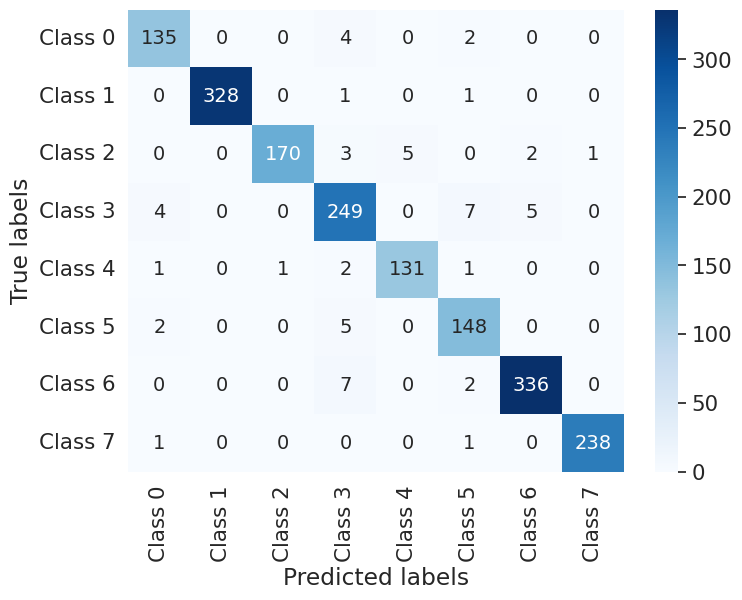

In [33]:
# Evaluate the model on the test set

test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')



# Predict class probabilities and get predicted classes

test_predictions = model.predict(X_test, verbose=0)

test_predictions = np.argmax(test_predictions, axis=-1)



# Extract ground truth classes

test_gt = y_test



# Calculate and display test set accuracy

test_accuracy = accuracy_score(test_gt, test_predictions)

print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')



# Calculate and display test set precision

test_precision = precision_score(test_gt, test_predictions, average='weighted')

print(f'Precision score over the test set: {round(test_precision, 4)}')



# Calculate and display test set recall

test_recall = recall_score(test_gt, test_predictions, average='weighted')

print(f'Recall score over the test set: {round(test_recall, 4)}')



# Calculate and display test set F1 score

test_f1 = f1_score(test_gt, test_predictions, average='weighted')

print(f'F1 score over the test set: {round(test_f1, 4)}')



# Compute the confusion matrix

cm = confusion_matrix(test_gt, test_predictions)



# Create labels combining confusion matrix values

labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)



# Plot the confusion matrix with class labels

plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=labels, fmt='', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'], cmap='Blues')

plt.xlabel('Predicted labels')

plt.ylabel('True labels')

plt.show()


In [34]:
# Save the trained model to a file with the accuracy included in the filename

model_filename = 'weights.keras'

model.save(model_filename)

In [35]:
import keras as tfk

ft_model = tfk.models.load_model('weights.keras')

In [36]:
%%writefile model.py

import numpy as np



import tensorflow as tf

from tensorflow import keras as tfk

from keras import layers as tfkl



class Model:

    def __init__(self):

        """

        Initialize the internal state of the model. Note that the __init__

        method cannot accept any arguments.



        The following is an example loading the weights of a pre-trained

        model.

        """

        self.model = tfk.models.load_model('weights.keras')



    def predict(self, X):

        """

        Predict the labels corresponding to the input X. Note that X is a numpy

        array of shape (n_samples, 96, 96, 3) and the output should be a numpy

        array of shape (n_samples,). Therefore, outputs must no be one-hot

        encoded.



        The following is an example of a prediction from the pre-trained model

        loaded in the __init__ method.

        """

        y_pred = self.model.predict(X)

        # Convert the predicted probabilities to class labels

        y_pred_classes = np.argmax(y_pred, axis=1)

        return y_pred_classes


Writing model.py


In [37]:
from datetime import datetime

filename = f'Kaggle_21_11_2024.zip'



# Add files to the zip command if needed

!zip {filename} model.py weights.keras


  adding: model.py (deflated 56%)
  adding: weights.keras (deflated 12%)
